In [7]:
########################################
#LIBRARIES

import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
import pydde as dde
import matplotlib.pyplot as plt
import json
import sklearn
import os

########################################
#PARAMETERS
nTimeSteps = 60; #at 60 Hz
print(f'nTimeSteps: {nTimeSteps}')
epochs = 150
samplenum = 15000
samplenum_test = 5000
minibatch_size= 50
hiddenlayers = [180, 200]
input_size = 15
output_size = 3*nTimeSteps
use_case = 'varstart'
learning_rate = 0.001
LRdecay = 0.7
model_file_path = '../Trained_Models/'
sample_file_path = f'../Data/Samples/data_' + use_case +f'_{nTimeSteps}tsteps_1507/'
simulation_file_path = '../Data/Simulations/pm_stiff.sim'
objective_file_path = f'../Data/Objectives/pm_target.obj'
# set log level
dde.set_log_level(dde.LogLevel.off)
print(os.listdir(sample_file_path))

dyn = dde.DynamicSequence()
dyn.loadFile(simulation_file_path, nTimeSteps)

nTimeSteps: 60
['data_1.json', 'data_20.json', 'data_16.json', '.DS_Store', 'data_17.json', 'data_0.json', 'data_10.json', 'Sampling_varstart.py', 'data_7.json', 'data_test', 'data_6.json', 'data_11.json', 'Description.json', 'data_9.json', 'data_12.json', 'data_5.json', 'data_4.json', 'data_8.json', 'data_13.json', 'data_3.json', 'data_18.json', 'vari60.out', 'data_14.json', 'data_15.json', 'data_2.json', 'data_19.json']


In [8]:
#########################################
#LOAD TRAINING SAMPLES
number_of_files = len(os.listdir(sample_file_path))-5
with open(sample_file_path + f'data_0.json') as json_file:
    data = json.load(json_file)
    filesize = len(data['q_target'])
samplenum_temp = filesize*number_of_files
input = np.zeros((samplenum_temp, input_size))

p = np.zeros((samplenum_temp, dyn.nParameters*nTimeSteps))
input = np.zeros((samplenum_temp, input_size))

for filenum in range(number_of_files):
    with open(sample_file_path + f'data_{filenum}.json') as json_file:
        data = json.load(json_file)
        filesize = len(data['q_target'])
        for i, p_i in enumerate(data['p']):
            p[filenum*filesize+i, :] = np.array(p_i)
        for i, q_target_i in enumerate(data['q_target']):
            input[filenum*filesize+i, 0:3] = np.array(q_target_i)
        for i, q_i in enumerate(data['q']):
            input[filenum*filesize+i, 3:6] = np.array(q_i)
        for i, qdot_i in enumerate(data['qdot']):
            input[filenum*filesize+i, 6:9] = np.array(qdot_i)
        #for i, qddot_i in enumerate(data['qddot']):
        #    input[filenum*filesize+i, 9:12] = np.array(qddot_i)
        for i, p_now_i in enumerate(data['p_now']):
            input[filenum*filesize+i, 12:15] = np.array(p_now_i) - input[filenum*filesize+i, 3:6]

#Remove zeros
p_data = p[~(input == 0).all(1)]
data = input[~(input == 0).all(1)]
print(f'Shape of DATA after removing failed samples:{data.shape}')
print(f'Shape of P after removing failed samples:{p_data.shape}')
data = data[0:samplenum, :]
p_data = p_data[0:samplenum, :]

#normalize qddot
'''
def minmaxscale(input, extrema):
    if extrema == None:
        maximas= []
        minimas= []
        for i in range(len(input[0, :])):
            maximas.append(np.max(input[:,i]))
            minimas.append(np.min(input[:,i]))
        max = np.max(maximas)
        min = np.min(minimas)
        extrema = np.max([max, np.linalg.norm(min)])
        scaled = (input+extrema)/(2*extrema)
        return scaled, extrema
    else:
        scaled = (input+extrema)/(2*extrema)
        return scaled
print(input[0:4, 9:12])
data[:, 6:9], extr_qdot = minmaxscale(data[:, 6:9], None)
data[:, 9:12], extr_qddot = minmaxscale(data[:, 9:12], None)
p_data, extr_p = minmaxscale(p_data, None)
print(data[0:4, 9:12])
'''

input = torch.tensor(data).float()
p = torch.tensor(p_data).float()

print(f'Shape of input: {input.shape}')
print(f'Shape of p: {p.shape}')

Shape of DATA after removing failed samples:(20915, 15)
Shape of P after removing failed samples:(20915, 180)
Shape of input: torch.Size([15000, 15])
Shape of p: torch.Size([15000, 180])


In [9]:
#########################################
#LOAD TEST SAMPLES

number_of_files_test = len(os.listdir(sample_file_path + 'data_test/'))
samplenum_test_temp = 1000*number_of_files_test

p_test = np.zeros((3*nTimeSteps, samplenum_test_temp))
input_test = np.zeros((samplenum_test_temp, input_size))

for filenum in range(number_of_files_test):
    with open(sample_file_path + f'data_test/data_{filenum}.json') as json_file:
        data = json.load(json_file)
        filesize = len(data['q_target'])
        for i, p_i in enumerate(data['p']):
            p_test[:, filenum*filesize+i] = np.array(p_i)
        for i, q_target_i in enumerate(data['q_target']):
            input_test[filenum*filesize+i, 0:3] = np.array(q_target_i)
        for i, q_i in enumerate(data['q']):
            input_test[filenum*filesize+i, 3:6] = np.array(q_i)
        for i, qdot_i in enumerate(data['qdot']):
            input_test[filenum*filesize+i, 6:9] = np.array(qdot_i)
        #for i, qddot_i in enumerate(data['qddot']):
        #   input_test[filenum*filesize+i, 9:12] = np.array(qddot_i)
        for i, p_now_i in enumerate(data['p_now']):
            input_test[filenum*filesize+i, 12:15] = np.array(p_now_i) - input_test[filenum*filesize+i, 3:6]
p_test = p_test.transpose()

print(f'Shape of input_test: {input_test.shape}')
print(f'Shape of p_test: {p_test.shape}')
#Remove zeros
p_test = p_test[~(input_test == 0).all(1)]
input_test = input_test[~(input_test == 0).all(1)]
print(f'Shape of DATA_TEST after removing failed samples:{input_test.shape}')
print(f'Shape of P_TEST after removing failed samples:{p_test.shape}')
input_test = input_test[0:samplenum_test, :]
p_test = p_test[0:samplenum_test, :]

input_test = torch.tensor(input_test).float()
p_test = torch.tensor(p_test).float()

print(f'Shape of input: {input_test.shape}')
print(f'Shape of p: {p_test.shape}')

Shape of input_test: (6000, 15)
Shape of p_test: (6000, 180)
Shape of DATA_TEST after removing failed samples:(5975, 15)
Shape of P_TEST after removing failed samples:(5975, 180)
Shape of input: torch.Size([5000, 15])
Shape of p: torch.Size([5000, 180])


epoch:   0/150    LR:   0.001000  loss: 4.61744165
epoch:  15/150    LR:   0.000700  loss: 0.43599054
epoch:  30/150    LR:   0.000490  loss: 0.28301761
epoch:  45/150    LR:   0.000343  loss: 0.29083082
epoch:  60/150    LR:   0.000240  loss: 0.25725549
epoch:  75/150    LR:   0.000168  loss: 0.25072658
epoch:  90/150    LR:   0.000118  loss: 0.23618542
epoch: 105/150    LR:   0.000082  loss: 0.21722645
epoch: 120/150    LR:   0.000058  loss: 0.21281078
epoch: 135/150    LR:   0.000040  loss: 0.20645946
epoch: 149 final loss: 0.20418786

Training completed. Total duration: 21.963 min


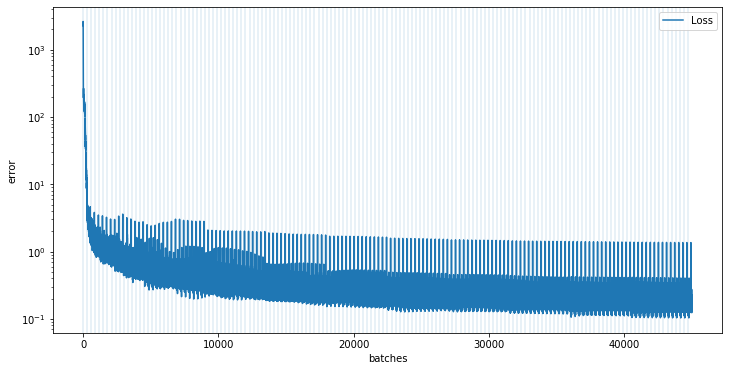

In [10]:
########################################
#BUILD CUSTOM MODEL
class PassiveLearn(nn.Module):

    def __init__(self, n_in, out_sz):
        super(PassiveLearn, self).__init__()

        self.L_in = nn.Linear(n_in, hiddenlayers[0])
        self.H1 = nn.Linear(hiddenlayers[0], hiddenlayers[1])
        self.H2 = nn.Linear(hiddenlayers[1], out_sz)
        #self.H3 = nn.Linear(h[2], 3*time_length)
        self.L_out = nn.Linear(out_sz, out_sz)
        self.Relu = nn.ReLU(inplace=True)
        #self.drop = nn.Dropout(p=0.3)
        #self.norm1 = nn.BatchNorm2d(h[0])
        #self.norm2 = nn.BatchNorm2d(h[1])
    
    def forward(self, input):
        x = self.L_in(input)
        #x = self.norm1(x)
        #x = self.drop(x)
        x = self.Relu(x)
        x = self.H1(x)
        #x = self.norm2(x)
        x = self.Relu(x)
        x = self.H2(x)
        x = self.Relu(x)
        #x = self.H3(x)
        #x = self.Relu(x)
        x = self.L_out(x)
        return x

model = PassiveLearn(input_size, output_size)

criterion = nn.SmoothL1Loss(reduction = 'sum')  # RMSE = np.sqrt(MSE)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler= torch.optim.lr_scheduler.StepLR(optimizer, step_size = 15, gamma=LRdecay, last_epoch=-1)

################################################
#TRAIN THE MODEL

torch.autograd.set_detect_anomaly(True)

start_time = time.time()
weight_c1 = 1 # p error condition
batch = np.floor(samplenum/minibatch_size).astype(int)
losses= []
p_smoothness_errors = []
basic_errors = [] #y_end_ and p_start error
for e in range(epochs):
    for b in range(batch):
        loss_batch = 0
        smoothness_error_batch = 0
        input_i = input[b*minibatch_size:b*minibatch_size+minibatch_size,:]
        p_i = p[b*minibatch_size:b*minibatch_size+minibatch_size,:]
        p_pred = model(input_i)
        #error claculation
        loss_batch = weight_c1* criterion(p_pred, p_i)
        losses.append(loss_batch)
        optimizer.zero_grad()
        #Back Prop
        loss_batch.backward()
        optimizer.step()
    scheduler.step()
    LR= scheduler.get_lr()
    if e%(epochs/10) == 0:
        print(f'epoch: {e:3}/{epochs}    LR: {LR[0]:10.6f}  loss: {loss_batch.item():10.8f}')

print(f'epoch: {e:3} final loss: {loss_batch.item():10.8f}') # print the last line
print(f'\nTraining completed. Total duration: {(time.time() - start_time)/60:.3f} min') # print the time elapsed

##################################################
#Plot loss for each batch after each epoch
epoch_lines = np.arange(0, epochs*batch, batch)
plt.figure(figsize = [12,6])
loss = plt.plot(losses, label = 'Loss')
plt.legend()
plt.yscale('log')
plt.ylabel('error')
plt.xlabel('batches')
for xc in epoch_lines:
    plt.axvline(x=xc, linewidth = 0.2)
plt.show()

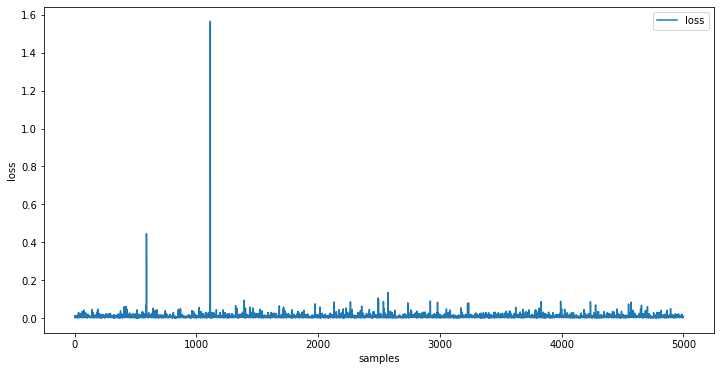

0.009353759


In [40]:
####################################################
#Test the data
samplenum_test = len(input_test[:,0])
losses_test= []
with torch.no_grad():
    for i in range(samplenum_test):
        p_val = model(input_test[i, :])
        loss_test = criterion(p_val,p_test[i,:])
        losses_test.append(loss_test.clone().numpy())
#plot test errors
plt.figure(figsize = [12,6])
loss_test_plot = plt.plot(losses_test, label = 'loss')
plt.legend()
plt.ylabel('loss')
plt.xlabel('samples')
plt.show()
tot_error = np.mean(losses_test)
print(tot_error)

## PLOTS

In [24]:
#relative error
rel_errors_norm = []
with torch.no_grad():
    for i in range(samplenum_test):
            p_val = model(input_test[i, :])
            p_truth = p_test[i,:]
            rel_error = np.linalg.norm((p_val - p_truth)/p_truth)
            rel_errors_norm.append(rel_error)

rel_errors_sum = torch.zeros(3*nTimeSteps)
abs_errors_sum = torch.zeros(3*nTimeSteps)
with torch.no_grad():
    for i in range(samplenum_test):
            p_val = model(input_test[i, :])
            p_truth = p_test[i,:]
            rel_error = (p_val - p_truth)/p_truth
            abs_error = np.abs(p_val - p_truth)
            rel_errors_sum = rel_errors_sum + rel_error
            abs_errors_sum = abs_errors_sum + abs_error
x_err_rel = rel_errors_sum[0::3]/(samplenum_test)
y_err_rel = rel_errors_sum[1::3]/(samplenum_test)
z_err_rel = rel_errors_sum[2::3]/(samplenum_test)

x_err = abs_errors_sum[0::3]/(samplenum_test)
y_err = abs_errors_sum[1::3]/(samplenum_test)
z_err = abs_errors_sum[2::3]/(samplenum_test)

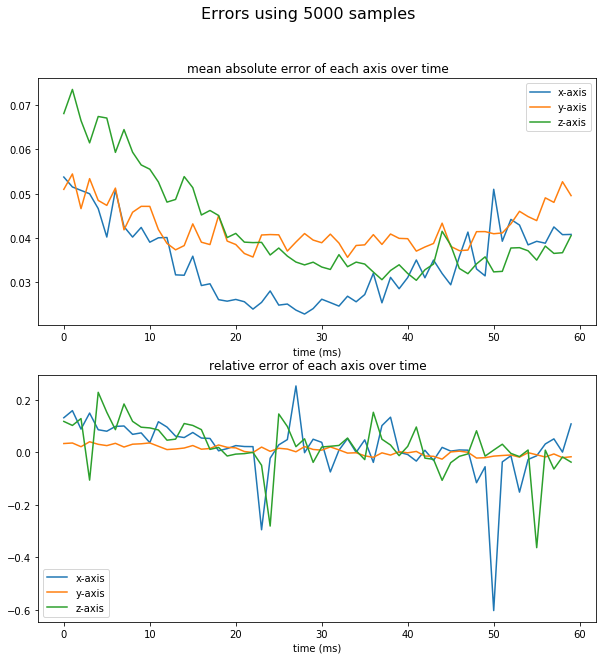

In [25]:
plt.figure(figsize = [10,10])
plt.suptitle('Errors using 5000 samples', fontsize=16)

plt.subplot(2, 1, 2)
plt.plot(x_err_rel, label = 'x-axis')
plt.plot(y_err_rel, label = 'y-axis')
plt.plot(z_err_rel, label = 'z-axis')
plt.xlabel('time (ms)')
plt.title('relative error of each axis over time')
plt.legend()

plt.subplot(2, 1, 1)
plt.plot(x_err, label = 'x-axis')
plt.plot(y_err, label = 'y-axis')
plt.plot(z_err, label = 'z-axis')
plt.xlabel('time (ms)')
plt.title('mean absolute error of each axis over time')
plt.legend()
plt.show()

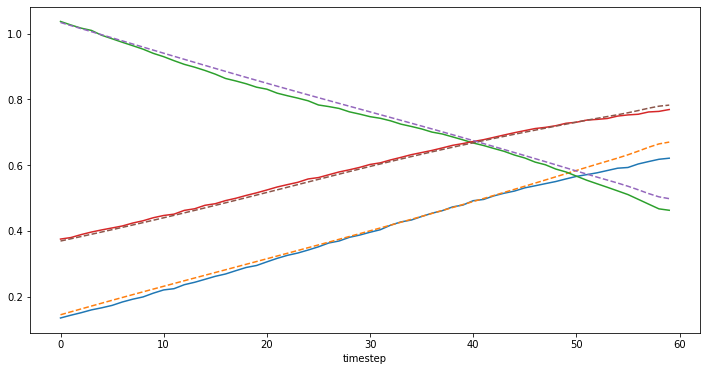

In [5]:
#x, y and z plot
randomsample = 98
with torch.no_grad():
        p_val = model(input_test[randomsample, :])
        p_truth = p_test[randomsample,:]
        x_val = p_val[0::3]
        y_val = p_val[1::3]
        z_val = p_val[2::3]
        x_truth = p_truth[0::3]
        y_truth = p_truth[1::3]
        z_truth = p_truth[2::3]
            

plt.figure(figsize = [12,6])
plt.plot(x_val)
plt.plot(x_truth, '--')
plt.plot(y_val)
plt.plot(z_val)
plt.plot(y_truth, '--')
plt.plot(z_truth, '--')

plt.xlabel('timestep')
plt.show()

In [6]:
#####################################################
#SAVE MODEL
samplenum_target = samplenum
if samplenum_target == 15000:
    timestr = time.strftime("%m%d")
    #Save entire Model
    torch.save(model, model_file_path + 'Model_passive_' + use_case + f'_{nTimeSteps}tsteps_{samplenum}s_{epochs}e_{LRdecay}lr_' + timestr + '.pt')
    torch.save(model, model_file_path + 'Model_passive_' + use_case + f'_{nTimeSteps}tsteps_latest.pt')

    #Save parameters of Model
    torch.save(model.state_dict(), model_file_path + 'state_dict/Trained_Model_statedict_passive_' + use_case + f'_{nTimeSteps}tsteps_{samplenum}s_{epochs}e_{LRdecay}lr_' + timestr + '.pt')
    torch.save(model.state_dict(), model_file_path + 'state_dict/Model_statedict_passive_' + use_case + f'_{nTimeSteps}tsteps_latest.pt')

    #Convert to Torch Script and save for CPP application
    input_example = input[4, :]
    traced_script_module = torch.jit.trace(model, input_example)

    # Test the torch script
    #test_input = torch.tensor([0, 2, 0.5])
    #original = model(test_input)
    #output_example = traced_script_module(test_input)

    traced_script_module.save(model_file_path + 'Serialized_Models/Serialized_model_passive_' + use_case + f'_{nTimeSteps}tsteps_latest.pt')
    traced_script_module.save(model_file_path + 'Serialized_Models/Serialized_model_passive_' + use_case + f'_{nTimeSteps}tsteps_{samplenum}s_{epochs}e_{LRdecay}lr_' + timestr + '.pt')
    print('Model saved')

else:
    timestr = time.strftime("%m%d")
    #Save entire Model
    torch.save(model, model_file_path + 'Model_passive_' + use_case + f'_{nTimeSteps}tsteps_{samplenum}s_{epochs}e_{LRdecay}lr_' + timestr + f'_{samplenum_target}.pt')
    torch.save(model, model_file_path + 'Model_passive_' + use_case + f'_{nTimeSteps}tsteps_latest_{samplenum_target}.pt')

    #Save parameters of Model
    torch.save(model.state_dict(), model_file_path + 'state_dict/Model_statedict_passive_' + use_case + f'_{nTimeSteps}tsteps_{samplenum}s_{epochs}e_{LRdecay}lr_' + timestr + f'_{samplenum_target}.pt')
    torch.save(model.state_dict(), model_file_path + 'state_dict/Model_statedict_passive_' + use_case + f'_{nTimeSteps}tsteps_latest_{samplenum_target}.pt')

    #Convert to Torch Script and save for CPP application
    input_example = input[4, :]
    traced_script_module = torch.jit.trace(model, input_example)

    # Test the torch script
    #test_input = torch.tensor([0, 2, 0.5])
    #original = model(test_input)
    #output_example = traced_script_module(test_input)

    traced_script_module.save(model_file_path + 'Serialized_Models/Serialized_model_passive_' + use_case + f'_{nTimeSteps}tsteps_latest_{samplenum_target}.pt')
    traced_script_module.save(model_file_path + 'Serialized_Models/Serialized_model_passive_' + use_case + f'_{nTimeSteps}tsteps_{samplenum}s_{epochs}e_{LRdecay}lr_' + timestr + f'_{samplenum_target}.pt')
    print('Model saved')

Model saved


In [35]:
#####################################################
# !!!!!!!!!!!!!!!NOT READY YET!!!!!!!!!!!!!!
#TEST THE MODEL

# Generate simulation
dyn = dde.DynamicSequence()
dyn.loadFile(simulation_file_path, nTimeSteps)
p_init = np.zeros(dyn.p0.size*nTimeSteps)
for i in range(0,nTimeSteps):
	p_init[i*dyn.p0.size : (i+1)*dyn.p0.size] = dyn.p0
state_init = dyn.q(p_init)
r = dyn.r(state_init, p_init)
dr = dyn.dr_dp(state_init, p_init)
dq = dyn.dq_dp(state_init, p_init)

#Load objective
obj = dde.InverseObjective(dyn)

#obj.loadFile(objective_file_path)
data = json.load(open(objective_file_path))
data['objectives']['pmTargetPositions'][0]['targetPos'] = ([[0.5],[0.5],[0.5]])
obj.loadJson(data)

y_target_test_= torch.tensor([0.5, 0.5, 0.5])
p_ = model(y_target_test_)
p_ = p_.detach().numpy()
newton = dde.Newton()
p_truth_ = newton.minimize(obj, p_init)
y_target_ = y_target_test_.detach().numpy()

yTraj_test_ = dyn.q(p_)
yTraj_truth_ = dyn.q(p_truth_)

print('TEST OF THE MODEL')
print(f'\ntest for y_target:\n {y_target_test_}')
print(f'\nevaluated y_end:\n {yTraj_test_.q[-3:]}')
print(f'\nsimulated traj_opt y_end with p_truth:\n {yTraj_truth_.q[-3:]}')
print(f'\ndifference of y_end:\n {np.sum(yTraj_test_.q[-3:]-y_target_)}')
print(f'\nlast 6 entries of p predicted:\n {p_[-6:].transpose()}')
print(f'\nlast 6 entries of p from traj_opt:\n {p_truth_[-6:].transpose()}')

TEST OF THE MODEL

test for y_target:
 tensor([0.5000, 0.5000, 0.5000])

evaluated y_end:
 [0.49432393 0.49335369 0.4951183 ]

simulated traj_opt y_end with p_truth:
 [0.49560763 0.49293486 0.49560763]

difference of y_end:
 -0.017204084384135065

last 6 entries of p predicted:
 [0.47749302 1.2182992  0.47810224 0.4774424  1.2185354  0.47826165]

last 6 entries of p from traj_opt:
 [0.47875592 1.21774452 0.47875592 0.478775   1.21785194 0.478775  ]
